In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = './hy_round1_train_20200102/'
train_file = os.listdir(path)
data = []
for each in train_file:
    each_path = os.path.join(path, each)
    temp = pd.read_csv(each_path)[['渔船ID', 'x', 'y', '速度', '方向', 'time', 'type']]
    data.append(temp)
train = pd.concat(data)
train.rename(columns = {'渔船ID':'ID', '速度' : 'speed', '方向' : 'direction'}, inplace = True)

In [3]:
train.head()

,ID,x,y,speed,direction,time,type
0,154,6.347783e+06,5.358898e+06,9.88,294,1117 11:56:10,围网
1,154,6.350684e+06,5.358233e+06,10.09,287,1117 11:46:33,围网
2,154,6.353685e+06,5.357459e+06,10.09,287,1117 11:36:52,围网
3,154,6.360489e+06,5.356461e+06,10.09,287,1117 11:26:54,围网
4,154,6.360489e+06,5.356461e+06,10.09,287,1117 11:16:20,围网


In [4]:
train.describe()

,ID,x,y,speed,direction
count,2.699638e+06,2.699638e+06,2.699638e+06,2.699638e+06,2.699638e+06
mean,3.496035e+03,6.277243e+06,5.271190e+06,1.784449e+00,1.151533e+02
std,2.020781e+03,2.698065e+05,2.544160e+05,2.478862e+00,1.168515e+02
min,0.000000e+00,5.000250e+06,3.345433e+06,0.000000e+00,0.000000e+00
25%,1.739000e+03,6.118054e+06,5.114766e+06,1.100000e-01,0.000000e+00
50%,3.502000e+03,6.246522e+06,5.229463e+06,3.200000e-01,8.100000e+01
75%,5.243000e+03,6.365916e+06,5.379267e+06,3.290000e+00,2.170000e+02
max,6.999000e+03,7.133785e+06,7.667581e+06,1.001600e+02,3.600000e+02


从上面的描述中可以看出，渔船ID为从0到6999，其方位x,y最大最小值均为6位数，速度从0到100多，方向从0到360，时间稍后处理，type为预测类标。
所以刚开始我们的思路是，按照渔船ID为分割，对每条渔船以时间为事件发生的轴，以x,y,方向,速度为属性，进行绘图，对结构化的数据以图像处理的方法进行分析，当然这只是第一眼看到数据的方向，接下来要进行更深入的分析。

In [5]:
train.isnull().sum()

ID           0
x            0
y            0
speed        0
direction    0
time         0
type         0
dtype: int64

很高兴训练集的数据没有为空的，也就是说我们不需要进行差值和删除操作

In [6]:
train['type'].value_counts()

拖网    1681225
围网     626607
刺网     391806
Name: type, dtype: int64

In [7]:
train['type'] = train['type'].map({'拖网' : 0, '围网' : 1, '刺网' : 2})

本数据集的要求是，分析渔船北斗设备位置数据，得出该船的生产作业行为，具体判断出是拖网作业，围网作业，还是刺网作业，对于训练集而言可以看出标记没有超出这三种的，不需要进行删除。

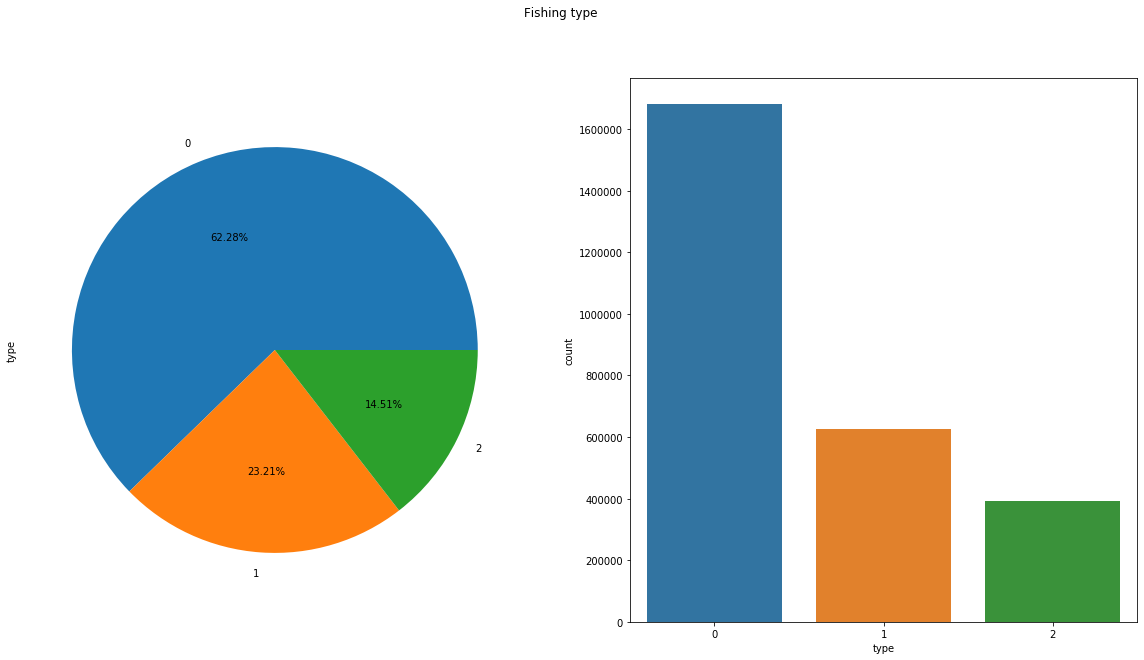

In [8]:
f,[ax1,ax2] = plt.subplots(1,2,figsize = (20,10))#生成子图 共1行2列 f为所有子图的大标题 
train['type'].value_counts().plot.pie(autopct = '%1.2f%%',ax = ax1)#饼图用plt.pie
sns.countplot(x = 'type',data = train,ax = ax2)#计数直方图用seaborn的countplot，比plt.bar方便一点
f.suptitle('Fishing type')#title
plt.show()

In [9]:
#python聚合函数 显示速度和作业方式的关系
train.groupby(['speed','type'])['type'].count()

speed   type
0.00    0       339874
        1       108919
        2        99429
0.05    0        68327
        1        21339
                 ...  
80.73   0            3
        1            2
90.83   0            2
93.15   1            1
100.16  0            2
Name: type, Length: 602, dtype: int64

Text(0.5, 1, 'Speed -> type influence')

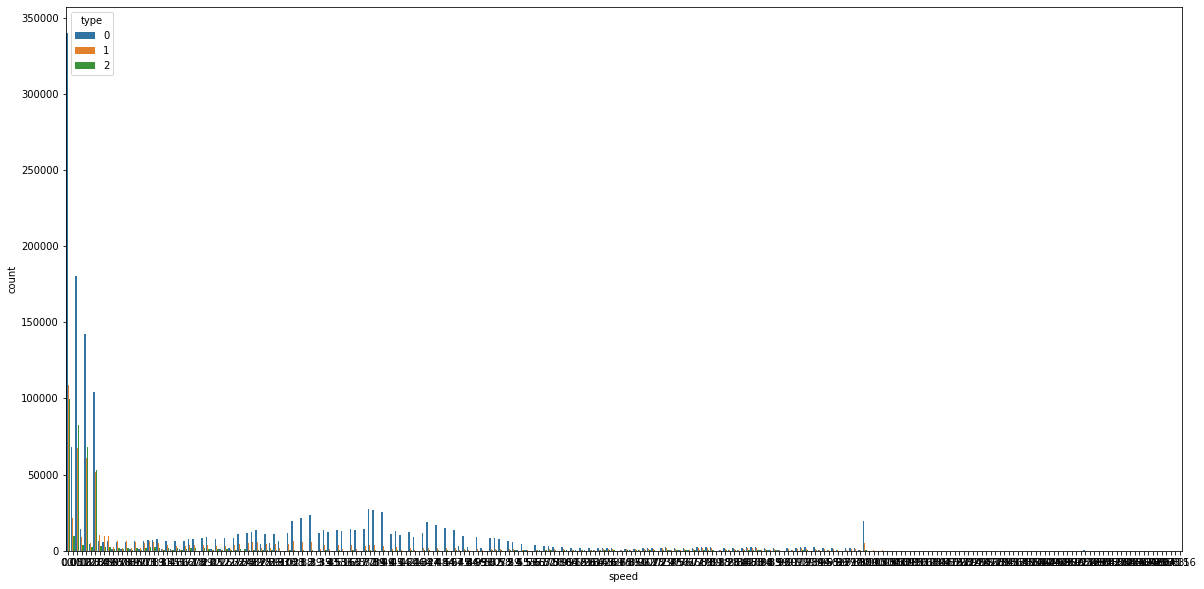

In [10]:
plt.figure(figsize = (20, 10))
sns.countplot(x = 'speed',hue = 'type',data = train)
ax1.set_title('Speed -> type influence')

首先我们需要知道一定的领域知识，拖网捕鱼就是渔船拖着一张网前行把鱼兜进来，围网是渔船绕着圈把一片水域围起来，主要捕捉顶层鱼群，刺网是拦截在鱼群迅游通道上面，让鱼群主动刺上来被缠住，具有一定的选择性。所以直观的来理解，显然拖网是需要渔船速度的，而刺网需要的速度是最小的，围网在某一特定时间如开始阶段需要渔船不断改变速度方向来完成设网。那么由此来理解上图，在速度很小的阶段围网和刺网有很多，但是在速度较大的阶段，渔船大多使用围网捕鱼。                         
但是显然地，上图的速度属性是连续数值，没有按照区间进行离散，所以分析起来很困难，下面我们对speed属性进行连续数值离散化操作

In [11]:
interval = [0,1,5,10,20,30,50,110]
train['speed'] = pd.cut(train['speed'], interval, labels = ['0', '1', '2', '3', '4', '5', '6'])
train.head()

,ID,x,y,speed,direction,time,type
0,154,6.347783e+06,5.358898e+06,2,294,1117 11:56:10,1
1,154,6.350684e+06,5.358233e+06,3,287,1117 11:46:33,1
2,154,6.353685e+06,5.357459e+06,3,287,1117 11:36:52,1
3,154,6.360489e+06,5.356461e+06,3,287,1117 11:26:54,1
4,154,6.360489e+06,5.356461e+06,3,287,1117 11:16:20,1


In [12]:
#python聚合函数 显示速度和作业方式的关系
train.groupby(['speed','type'])['type'].count()   

speed  type
0      0       554313
       1       272154
       2       236600
1      0       620985
       1       169019
       2        38239
2      0       145240
       1        69398
       2        16675
3      0        20438
       1         6963
       2          809
4      0          250
       1          103
       2           34
5      0           88
       1           43
       2           16
6      0           37
       1            8
       2            4
Name: type, dtype: int64

Text(0.5, 1, 'Speed -> type influence')

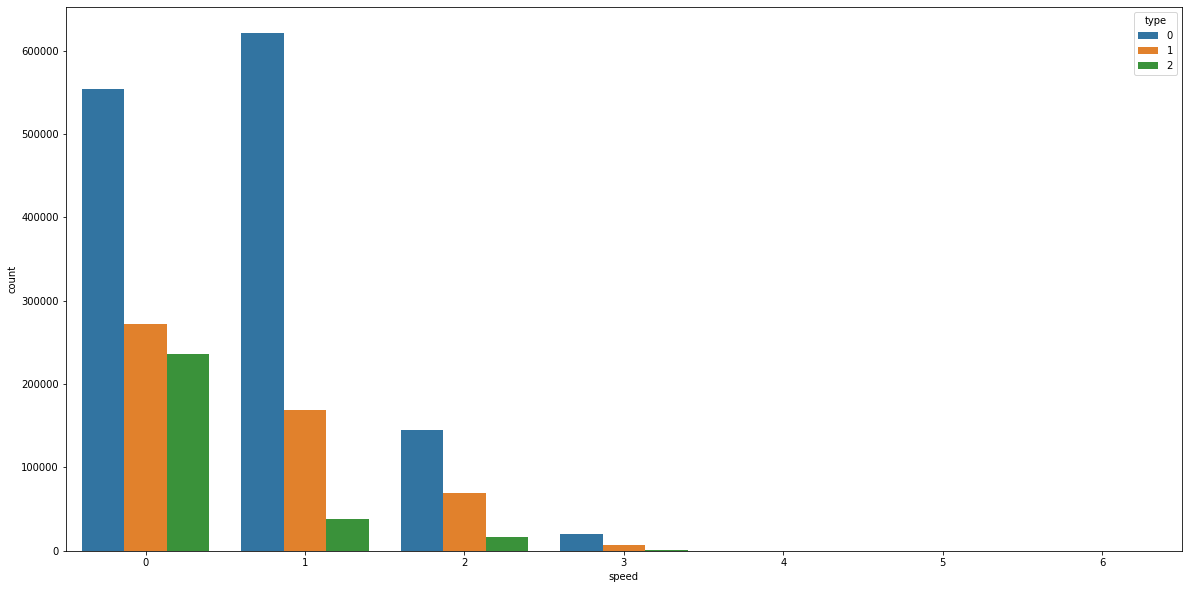

In [13]:
plt.figure(figsize = (20, 10))
sns.countplot(x = 'speed',hue = 'type',data = train)
ax1.set_title('Speed -> type influence')

现在对上图分析，我们将速度在(0,1)之间离散为0，即静止不动，可以看到此时的绿色即刺网占总刺网比重最大，因此刺网的特征就是静止捕鱼，而(1,5)的速度离散为1，可以看到低速行驶是拖网捕鱼的主要特征，围网捕鱼也符合低速行驶的特性，因此单纯就速度而言很难区分围网和拖网捕鱼，由此可以通过方向属性来进行分析。

In [14]:
#python聚合函数 显示方向和作业方式的关系
train.groupby(['direction','type'])['type'].count()

direction  type
0          0       535111
           1       173715
           2       159236
1          0         2602
           1         1439
                    ...  
359        1         1235
           2          572
360        0         3225
           1         1220
           2         4206
Name: type, Length: 1083, dtype: int64

Text(0.5, 1, 'Direction -> type influence')

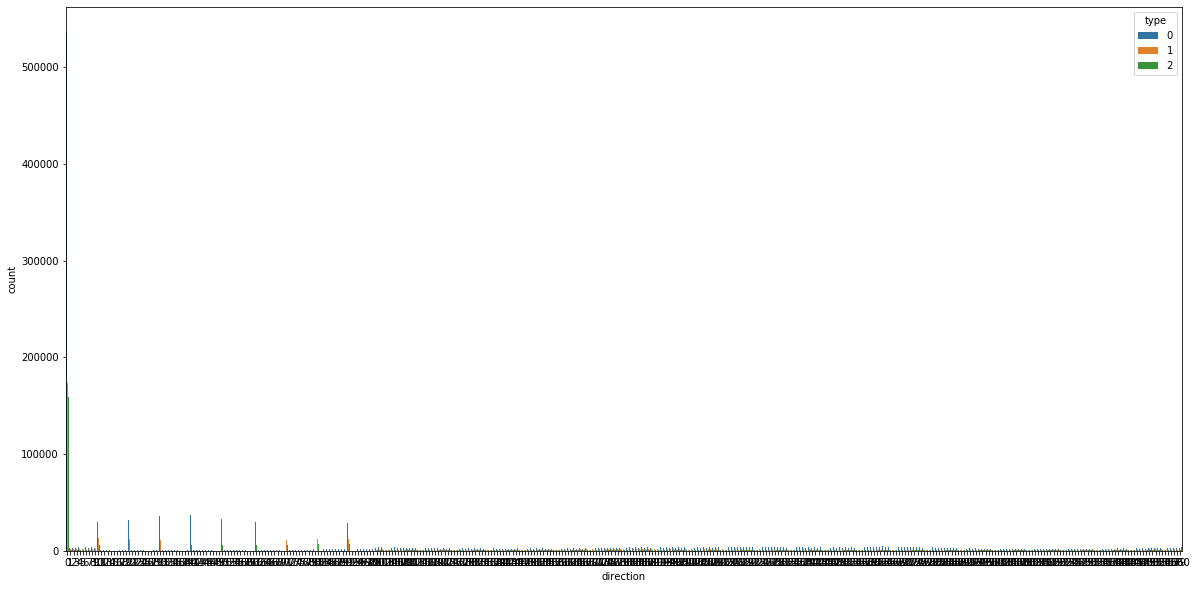

In [15]:
plt.figure(figsize = (20, 10))
sns.countplot(x = 'direction',hue = 'type',data = train)
ax1.set_title('Direction -> type influence')

上图对于方向的分析是错误的，因为单个的方向不能表示任何意义，考虑方向必须考虑某段时间内各个时刻方向的变化情况，这一点我考虑在之后的程序中，以图像的方式进行分析，初步的思路是对某个ID的船只，在其数据表示的各个时刻上以x,y为平面坐标，以方向为矢量方向，构建航向图，并以时间序列模型的方法进行分析

下面开始对时间进行转换，将其按照“月日 小时:分钟”的形式转换为python的datetime时间存储形式

In [16]:
train['time'] = pd.to_datetime(train['time'],format = '%m%d %H:%M:%S')
train.head()

,ID,x,y,speed,direction,time,type
0,154,6.347783e+06,5.358898e+06,2,294,1900-11-17 11:56:10,1
1,154,6.350684e+06,5.358233e+06,3,287,1900-11-17 11:46:33,1
2,154,6.353685e+06,5.357459e+06,3,287,1900-11-17 11:36:52,1
3,154,6.360489e+06,5.356461e+06,3,287,1900-11-17 11:26:54,1
4,154,6.360489e+06,5.356461e+06,3,287,1900-11-17 11:16:20,1


上面的时间戳转化，pandas在默认没有年份传入的时候从1900年开始计算，但是这对于我们之后的处理没有影响，因为本数据集的所有时间数据都是没有年份的脱敏数据，因此我们在研究其变化的时候通常都是几天之内的，在这里只是顺手进行了转化，在之后的转化中，我们只是以时间为事件发生的方向，由于时间跨度很小，年份在不同时间戳的差距上会被减去，所以在这里默认的年份对于我们的研究没有影响。